This notebook implements finite difference propagation and compares its performance against Fresnel integral-based multislice simulation. Refer to the following paper for mathematical details:
1.	L. Melchior and T. Salditt, "Finite difference methods for stationary and time-dependent X-ray propagation," Optics Express 25, 32090– (2017).

In [5]:
import numpy as np
import dxchange
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyfftw.interfaces.numpy_fft import fft2, ifft2, fftshift, ifftshift
from scipy.misc import imresize
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage.filters import laplace

In [15]:
PI = 3.1415927
def plot_img(a):
    plt.figure()
    plt.imshow(a)
    plt.show()

def plot_mod_and_phase(arr, figsize=(12, 5), title=None, unwrap=False):
    
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1, 2, 1)
    subfig1 = ax1.imshow(np.abs(arr))
    plt.colorbar(subfig1)
    plt.title('Modulus')
    ax2 = fig.add_subplot(1, 2, 2)
    phase_term = np.angle(arr)
    if unwrap:
        phase_term = np.unwrap(phase_term)
    subfig2 = ax2.imshow(phase_term)
    plt.colorbar(subfig2)
    plt.title('Phase')
    if title is not None:
        plt.suptitle(title)
    plt.show()

Again we have our MVP phantom object i.e. the cone model.

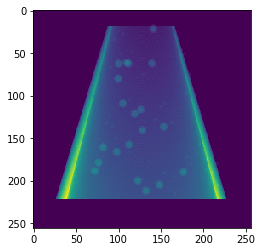

In [16]:
# read in object
grid_delta = np.load('phantom/grid_delta.npy')
grid_beta = np.load('phantom/grid_beta.npy')
# swap axis so that it is in [x, y, z] format
# grid_delta = np.swapaxes(grid_delta, 0, 1)
# grid_beta = np.swapaxes(grid_beta, 0, 1)
plot_img(np.sum(grid_delta, axis=2))

In [56]:
def finite_difference_propagation(wavefront, delta_slice, beta_slice, dist_nm, lmbda_nm, psize_nm):
    n_slice = 1 - delta_slice - 1j * beta_slice
    k = 2 * PI / lmbda_nm
    dudz = 1 / (2j * k * n_slice) * \
           (laplace(np.real(wavefront)) + 1j * laplace(np.imag(wavefront))) - \
           1j * k * (n_slice - 1) * wavefront / (psize_nm ** 2)
    wavefront = wavefront + dudz * dist_nm
    return wavefront

In [57]:
def initialize_wavefront(psize_cm, probe_shape, wavelen_nm, type='plane', **kwargs):
    psize_nm = psize_cm * 1.e7
    if type == 'spherical':
        s_r_cm = kwargs['s_r_cm']
        s_r_nm = s_r_cm * 1.e7
        y, x = (np.arange(probe_shape[0], dtype='float64'), np.arange(probe_shape[1], dtype='float64'))
        y = (y - float(y[-1]) / 2) * psize_nm
        x = (x - float(x[-1]) / 2) * psize_nm
        xx, yy = np.meshgrid(x, y)
        r = np.sqrt(xx ** 2 + yy ** 2 + s_r_nm ** 2)
        wavefront = np.exp(-1j * 2 * PI * r / wavelen_nm)
    elif type == 'plane':
        wavefront = np.ones(probe_shape, dtype='complex128')
    return wavefront

Now we initialize the wavefront and propagate it through the object.

In [58]:
energy_ev = 5000.
psize_cm = 1.e-7
psize_nm = psize_cm * 1.e7
lmbda_nm = 1240. / energy_ev

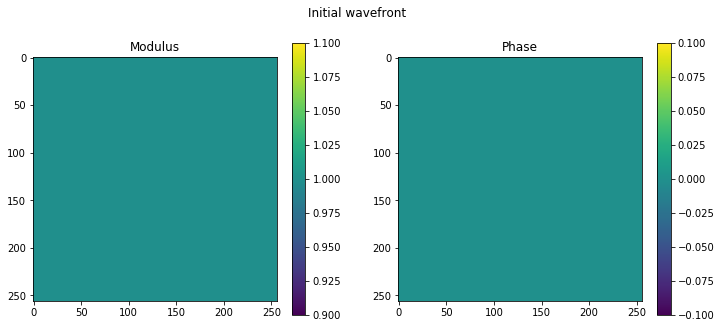

In [59]:
wavefront = initialize_wavefront(psize_cm, grid_delta.shape[0:2], lmbda_nm, type='plane')
plot_mod_and_phase(wavefront, title='Initial wavefront', unwrap=False)

100%|██████████| 256/256 [00:01<00:00, 144.64it/s]


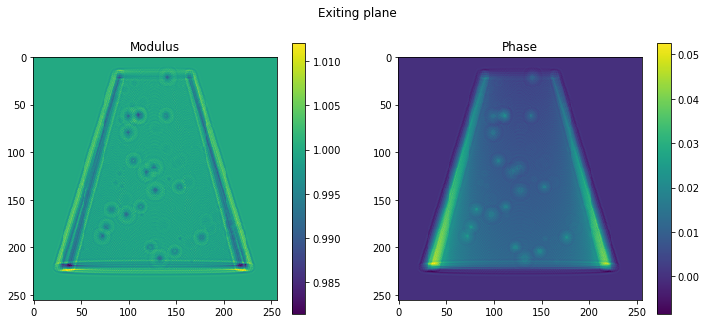

In [60]:
for i_slice in tqdm(range(grid_delta.shape[2])):
    delta_slice = grid_delta[:, :, i_slice]
    beta_slice = grid_beta[:, :, i_slice]
#     wavefront *= np.exp((kz * delta_slice) * 1j) * np.exp(-kz * beta_slice)
    wavefront = finite_difference_propagation(wavefront, 
                                              delta_slice,
                                              beta_slice,
                                              psize_nm, 
                                              lmbda_nm,
                                              psize_nm)
plot_mod_and_phase(wavefront, title='Exiting plane', unwrap=False)